In [1]:
import sys
import logging
from datetime import datetime, timedelta, date
from sqlalchemy.orm import sessionmaker
from os import remove, path
import pandas as pd
import requests
import mdsutils
from pyathena import connect
import boto3
import io

from pyathena import connect
from io import StringIO
import psycopg2 as ps
import time 

from datetime import date

from sklearn.metrics import roc_auc_score

import seaborn as sns
sns.set(style="darkgrid")

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-poster')

import lightgbm as lgb

In [2]:
train_start = '2020-06-01'
train_end = '2020-08-15'

In [3]:
def data_generator(train_start,train_end):
    
    conn = connect(s3_staging_dir='s3://aws-athena-query-results-782969481272-us-west-2',region_name='us-west-2')
    
    amplitude_date = str(pd.to_datetime(train_start) - pd.DateOffset(months=3)).split(' ')[0]

    sql = """
    with money as (
select applicant_id,
       borrower_id,
       business_account_number,
       account_open_date,
       current_account_balance,
       lifetime_credits_amount,
      first_funding_initiated_date,
      first_linked_bank_account_date,
      first_credit_date,
      first_credit_amount,
      account_owner
      from datalake_production_dwmart.banking_accounts_file ba
      where ba.account_owner = 'SoFi'
      and ba.account_status = 'Active'
      and ba.account_restricted_ind = 'false'
      and ba.account_open_date between date('{ts}') and date('{te}')
      and product_type = 'SoFi Money Cash Account'),
      
credit_pull as (select borrower_id,
        credit_pull_date,
        fico_score,
        education_loan_amount,
        total_tradelines_open,
        credit_card_loan_amount,
        total_outstanding_balance,
        num_inq_unsec_3m,
        num_inq_unsec_1m,
        pl_score
        from datalake_production_dw.credit_pull where  pull_type = 'MONEY'
        and credit_pull_date between date('{ts}') and date('{te}')),

 channel as (
select
      party_id,
      onboarding_started_date,
      onboarding_completed_date,
      onboarding_success_date,
      last_touch_channel,
      derived_platform
      from mdp_staging.money_ff_tof_v2
where onboarding_started_date between date('{ts}') and date('{te}')),
member_at_start as (select
       user_id as user_id_start,
       num_open_products as num_open_products_start,
       num_active_products as num_active_products_start,
       cross_sell_product_1_start_date,
       case when m.sl_open_ind = 'true' then 'Y' else 'N' end as open_sl_start,
       case when m.banking_open_ind = 'true' then 'Y' else 'N' end as open_banking_start,
       case when m.pl_open_ind = 'true' then 'Y' else 'N' end as open_pl_start,
       case when m.invest_open_ind = 'true' then 'Y' else 'N' end as open_invest_start,
       case when m.invest_active_ind = 'true' then 'Y' else 'N' end as active_invest_start,
       case when m.relay_open_ind = 'true' then 'Y' else 'N' end as open_relay_start,
       case when m.csm_active_ind = 'true' then 'Y' else 'N' end as active_csm_start,
       coalesce(invest_accounts_balance,0) as     invest_balance_start
from datalake_production_dwmart.member_summary_daily m
left join datalake_production_dwmart.banking_accounts_file ba on (m.user_id=ba.applicant_id  and m.reporting_date= ba.account_open_date- interval '2' day and sofi_employee_ind = 'false')
where ba.account_owner = 'SoFi'
      and ba.account_status = 'Active'
      and ba.account_restricted_ind = 'false'
      and ba.account_open_date between date('{ts}') and date('{te}')
      and ba.product_type = 'SoFi Money Cash Account'),
      
 install as (
    SELECT distinct
               user_id as user_id,
               min(platform) as install_platform,
               min(date(event_time AT TIME ZONE 'America/New_York' )) as first_session_date
               FROM amplitude.mobile m
                   where date(event_time AT TIME ZONE 'America/New_York' ) >= date('{ad}')
               group by 1 ),
member_at_3D as (select
       user_id as user_id_3d,
       invest_open_date as invest_open_date_3d,
       relay_open_date as relay_open_date_3d,
       csm_activation_date as csm_activation_date_3d,
       aggregation_activation_date as aggregation_activation_date_3d,
       coalesce(invest_accounts_balance,0) as     invest_balance_3d
from datalake_production_dwmart.member_summary_daily m
left join datalake_production_dwmart.banking_accounts_file ba on (m.user_id=ba.applicant_id
        and m.reporting_date= ba.account_open_date+ interval '2' day and sofi_employee_ind = 'false')
where ba.account_owner = 'SoFi'
      and ba.account_status = 'Active'
      and ba.account_restricted_ind = 'false'
      and ba.account_open_date between date('{ts}') and date('{te}')
      and ba.product_type = 'SoFi Money Cash Account'),
      
  money_at_30d as (select bf.borrower_id,
       sum(bf.lifetime_credits_amount) as D30_credits,
       sum(bf.lifetime_debits_amount) as D30_debits,
       sum(bf.total_current_month_direct_deposit_amount) as D30_dd_amount,
       sum(bf.current_account_balance) as D30_balance
      from datalake_production_dw.banking_account_daily_facts  bf
      join datalake_production_dwmart.banking_accounts_file ba on (bf.borrower_id = ba.borrower_id and bf.account_age=30)
      where ba.account_owner = 'SoFi'
        and ba.account_status = 'Active'
        and ba.account_restricted_ind = 'false'
        and ba.account_open_date between date('{ts}') and date('{te}')
        and product_type = 'SoFi Money Cash Account'
      group by 1)

      select
      m.applicant_id,
      m.account_open_date,
      m.business_account_number,
     --  case when date_diff('day',m.account_open_date , m.first_funding_initiated_date ) between 0 and 3 then 'Y' else 'N' end as fund_initiated_in_3D_flag,
      case when date_diff('day',m.account_open_date , m.first_credit_date ) between 0 and 3 then 'Y' else 'N' end as funded_in_3D_flag,
      case when date_diff('day',m.account_open_date , m.first_credit_date ) between 0 and 7 then 'Y' else 'N' end as funded_in_7D_flag,
      --case when (date_diff('day',m.account_open_date , m.first_credit_date ) between 0 and 7)
      --          and m30.D30_credits>500 then 'Y' else 'N' end as funded_in_7D_500plus_flag,
      -- credit bureau attributes
        case when cp.fico_score >850 then null else cp.fico_score   end as fico_score ,
        cp.education_loan_amount,
        cp.total_tradelines_open,
        cp.credit_card_loan_amount,
        cp.total_outstanding_balance,
        cp.num_inq_unsec_3m,
        cp.num_inq_unsec_1m,
        -- borrower
        pii.age as applicant_age,
        pii.housing_status,
        pii.non_verified_income,
        --pii.registration_date,
      -- channel attributes
      coalesce(date_diff('day',m.account_open_date , onboarding_success_date ),0) as days_to_complete_money_app,
      last_touch_channel,
      derived_platform,
    --- app install
       case when date_diff('day',first_session_date,m.account_open_date)>7 then 'before_money 7+'
            when date_diff('day',first_session_date,m.account_open_date)=0 then 'with_money'
            when date_diff('day',first_session_date,m.account_open_date)>0 and date_diff('day',first_session_date,m.account_open_date)<7 then 'before_money_0_6'
            else 'no install' end as time_to_install_app,
      -- member attributes at start
       coalesce(mem.num_open_products_start,0) as num_open_products_start,
       coalesce(mem.num_active_products_start,0) as num_active_products_start,
       date_diff('day',pii.registration_date, m.account_open_date ) as age_of_member_before_money,
       coalesce(mem.open_sl_start,'N') as open_sl_start,
       coalesce(mem.open_pl_start,'N') as open_pl_start,
       coalesce(mem.open_invest_start,'N') as open_invest_start,
       coalesce(mem.active_invest_start,'N') as active_invest_start,
       coalesce(mem.open_relay_start,'N') as open_relay_start,
       coalesce(mem.active_csm_start,'N') as active_csm_start,
       mem.invest_balance_start
      from money m
      left outer join credit_pull cp on     (m.borrower_id = cp.borrower_id and cp.credit_pull_date = m.account_open_date)
      left outer join channel c on           (m.applicant_id = c.party_id and c.onboarding_completed_date = m.account_open_date )
      left outer join member_at_start mem on     (m.applicant_id = mem.user_id_start )
      left outer join member_at_3D mem3d on     (m.applicant_id = mem3d.user_id_3d )
      left outer join install i on     (cast(m.applicant_id as varchar) = i.user_id )
      left outer join datalake_production_dwmart.borrowers_pii_file pii on     (m.applicant_id = pii.applicant_id )
      left outer join money_at_30d m30 on (m.borrower_id = m30.borrower_id)
""".format(ts=train_start, te = train_end, ad = amplitude_date)
    
    df = pd.read_sql(sql, conn)
    print('loaded %d lines of data'% len(df))
    return df

In [4]:
df = data_generator(train_start,train_end)

loaded 38066 lines of data


In [5]:
test_day = '2020-06-10'
str(pd.to_datetime(test_day) - pd.DateOffset(days=9)).split(' ')[0]

'2020-06-01'

In [6]:
str(pd.to_datetime(test_day) - pd.DateOffset(days=3)).split(' ')[0]

'2020-06-07'

In [7]:
# feature engineering
def feature_engineering(df,train_start,train_end,test_day):
    X = pd.DataFrame()
    X = pd.concat([X, df.account_open_date],axis = 1)
    feature_catgorical = ['time_to_install_app','derived_platform','last_touch_channel','housing_status']
    for ele in feature_catgorical:
        X = pd.concat([X, pd.get_dummies(df[ele], prefix=ele)], axis=1)
    YN_feature =['open_sl_start','open_pl_start','open_invest_start','active_invest_start','open_relay_start','active_csm_start']
    for ele in YN_feature:
        X = pd.concat([X,df[ele].map({ 'Y' : 0, 'N' : 1})], axis = 1)
    
    date_diff_test = 1/(pd.to_datetime(test_day) - pd.to_datetime(df.account_open_date)).dt.days
        
    X = pd.concat([df.applicant_id, X],axis = 1)
    X = pd.concat([df.business_account_number, X],axis = 1)
    
    Y_features = ['funded_in_3D_flag','funded_in_7D_flag']
    for ele in Y_features:
        X = pd.concat([df[ele].map({ 'Y' : 0, 'N' : 1}),X], axis = 1)

    numerical_features = ['fico_score',
 'education_loan_amount',
 'total_tradelines_open',
 'credit_card_loan_amount',
 'total_outstanding_balance',
 'num_inq_unsec_3m',
 'num_inq_unsec_1m',
 'applicant_age','non_verified_income',
 'days_to_complete_money_app','num_open_products_start',
 'num_active_products_start',
 'age_of_member_before_money','invest_balance_start']

    X = pd.concat([X,df[numerical_features]],axis = 1)
    
    X = X.assign(date_diff_test = date_diff_test)
    # train/test splitting
    X_train = X[(pd.to_datetime(X.account_open_date) >= pd.to_datetime(train_start))
                &(pd.to_datetime(X.account_open_date) <= pd.to_datetime(train_end))].iloc[:,5:]

    Y_train = X[(pd.to_datetime(X.account_open_date) >= pd.to_datetime(train_start))
                &(pd.to_datetime(X.account_open_date) <= pd.to_datetime(train_end))].iloc[:,1]
    X_test = X[pd.to_datetime(X.account_open_date) == pd.to_datetime(test_day)].iloc[:,5:]
    
    Y_test = X[pd.to_datetime(X.account_open_date) == pd.to_datetime(test_day)].iloc[:,1]
    
    return X_train,Y_train,X_test,Y_test

In [8]:
def model_training(X_train,Y_train,X_test,Y_test):
    
    # unbalanced dataset with ratio input in the model
    pos_wgt_scaling_factor = (len(Y_train) - Y_train.sum())/Y_train.sum()
    
    seed = 2020
    params = {
    "objective" : "binary",
    "metric" : "binary_logloss,auc",
    "boosting": 'gbdt',
    "it": 2000,
    "max_depth" :8,
    "num_leaves" : 30,
    "learning_rate" : 0.03,
    "feature_fraction" : 0.86,
    "subsample": 0.9,
    "lambda_l1": 0.0001,
    "lambda_l2": 0,
    "min_data_in_leaf": 100,
    "tree_learner": "feature",
    "bagging_seed" : seed,
    "verbosity" : 1,
    "seed": seed,
    'cat_smooth': 1}

    params['scale_pos_weight'] = pos_wgt_scaling_factor
    clf = lgb.LGBMClassifier(**params)
    clf.fit(X_train, Y_train)
    
    y_pred_gbm = clf.predict_proba(X_test)[:,1]
    roc_score = roc_auc_score(Y_test,y_pred_gbm)
    
    y_pred_gbm_train = clf.predict_proba(X_train)[:,1]
    roc_score_train = roc_auc_score(Y_train,y_pred_gbm_train)
    
    return pos_wgt_scaling_factor,roc_score,clf,roc_score_train

In [13]:
test_day = '2020-08-05'
auc_score = []
pos_neg_ratio_train = []
pos_neg_ratio_test = []
for d in range(10):
    cur_test_day = str(pd.to_datetime(test_day) + pd.DateOffset(days = d)).split(' ')[0]
    
    cur_train_start = str(pd.to_datetime(cur_test_day) - pd.DateOffset(days=10)).split(' ')[0]

    cur_train_end = str(pd.to_datetime(cur_test_day) - pd.DateOffset(days=3)).split(' ')[0]
    
    X_train,Y_train,X_test,Y_test = feature_engineering(df,cur_train_start,cur_train_end,cur_test_day)
    
    pos_wgt_scaling_factor,roc_score,clf,roc_score_train = model_training(X_train,Y_train,X_test,Y_test)
    
    test_scaling_factor = (len(Y_test) - Y_test.sum())/Y_test.sum()
    print(len(X_train),len(X_test),'%.2f'%(len(X_train)/len(X_test)),
          cur_test_day,'%.2f'%(1/pos_wgt_scaling_factor),'%.2f'%(1/test_scaling_factor),roc_score_train,roc_score)
    auc_score.append(roc_score)
    pos_neg_ratio_train.append(1/pos_wgt_scaling_factor)
    pos_neg_ratio_test.append(1/test_scaling_factor)

3488 594 5.87 2020-08-05 2.06 2.26 0.8531676828357094 0.7870012269284115
3705 577 6.42 2020-08-06 1.93 2.72 0.8510734667261289 0.7859730927992661
4022 2673 1.50 2020-08-07 1.84 0.64 0.8500226948234136 0.8424740331621838
4272 1650 2.59 2020-08-08 1.86 0.59 0.8556235344558683 0.8416283102143758
4432 999 4.44 2020-08-09 1.94 0.62 0.8569139798106169 0.8382515004577666
6680 1050 6.36 2020-08-10 1.22 0.56 0.8830607193707054 0.8468712513416251
7613 990 7.69 2020-08-11 1.01 0.51 0.8876060005617934 0.8642585256316636
8095 957 8.46 2020-08-12 0.91 0.65 0.8897539930629896 0.8559938843519977
8688 743 11.69 2020-08-13 0.84 0.83 0.8907152921357244 0.8343560523047703
9166 682 13.44 2020-08-14 0.77 1.63 0.8914960192430429 0.7888678952508739


Text(0.5, 1.0, 'ROC score from 08-05 to 08-07')

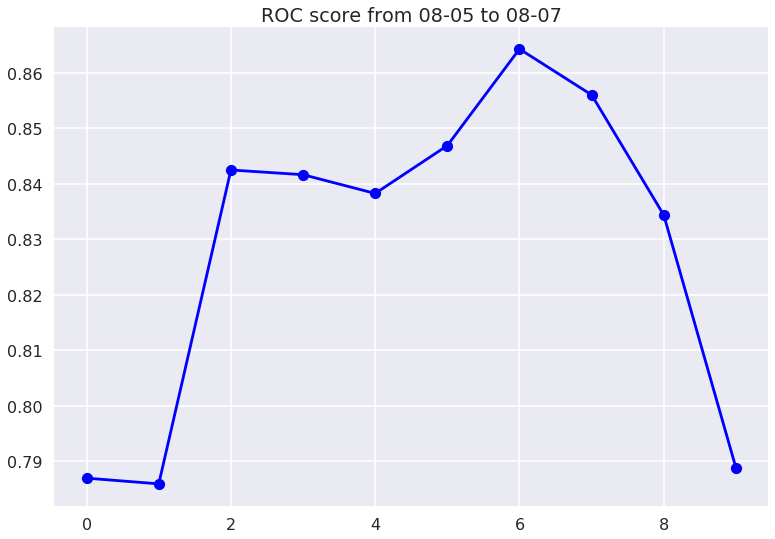

In [14]:
plt.style.use('seaborn-poster')
plt.plot(auc_score,'bo-')
plt.title('ROC score from 08-05 to 08-07')

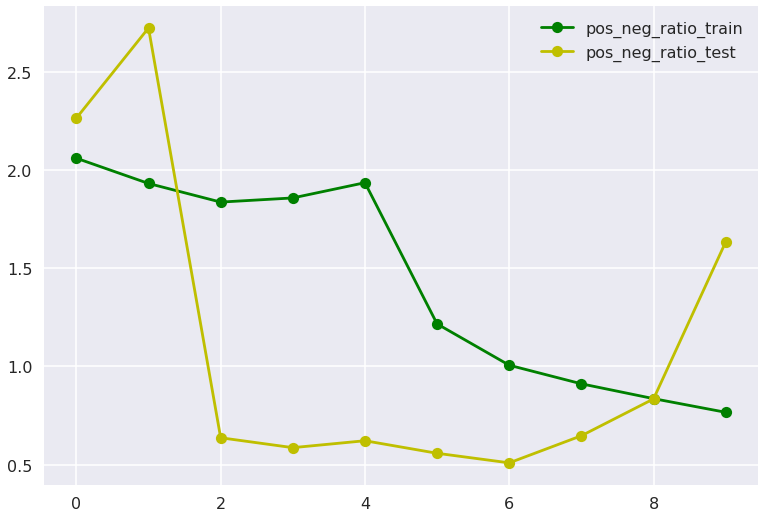

In [15]:
plt.plot(pos_neg_ratio_train,'go-')
plt.plot(pos_neg_ratio_test,'yo-')
plt.legend(['pos_neg_ratio_train','pos_neg_ratio_test']) 

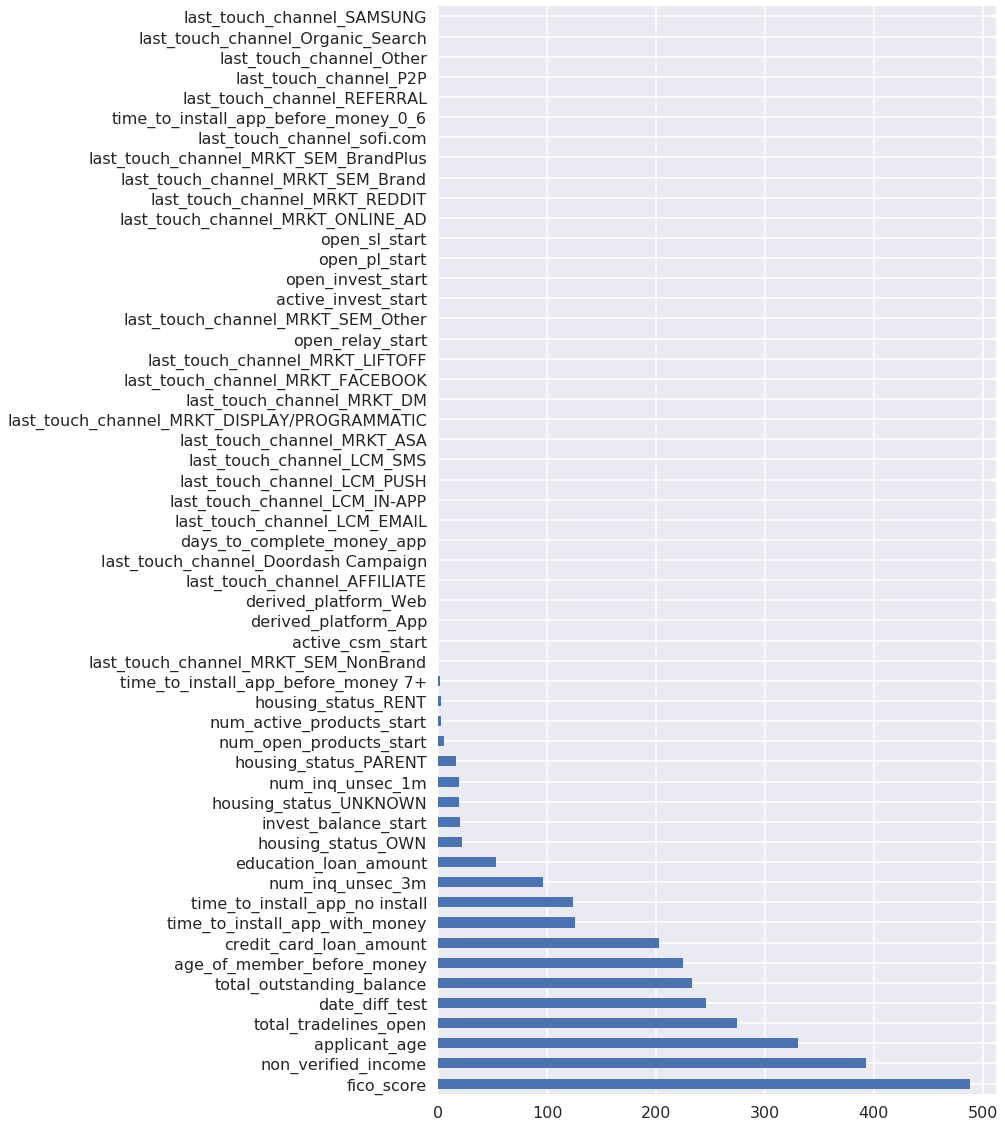

In [16]:
fig , ax = plt.subplots(figsize=(10,20))
(pd.Series(clf.feature_importances_, index=X_test.columns).nlargest(len(X_test.columns)).plot(kind='barh'))